In [96]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet
warnings.filterwarnings("ignore")

In [97]:
# Load the data
df = pd.read_csv('Commodity Prices Monthly.csv')

In [98]:
df.head() # Display the data

,Year,Variables,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2023,International Brent Crude Oil Price (US$/Barre...,83.94,83.92,79.65,82.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2022,International Brent Crude Oil Price (US$/Barre...,85.48,94.28,112.51,105.81,111.55,117.22,105.14,97.74,90.57,93.60,90.38,81.34
2,2021,International Brent Crude Oil Price (US$/Barre...,55.33,62.27,65.84,65.33,68.34,73.35,74.29,70.51,74.88,83.75,80.75,74.80
3,2020,International Brent Crude Oil Price (US$/Barre...,63.67,55.53,33.73,26.63,32.11,40.77,43.24,45.04,41.87,41.36,43.98,50.23
4,2019,International Brent Crude Oil Price (US$/Barre...,60.23,64.50,67.05,71.66,70.30,63.05,64.19,59.47,62.29,59.63,62.71,65.17


In [99]:
df.shape # Display the shape of the data

(23, 14)

In [100]:
df.dtypes # Display the data types of the data

Year           int64
Variables     object
Jan          float64
Feb          float64
Mar          float64
Apr          float64
May          float64
Jun          float64
Jul          float64
Aug          float64
Sep          float64
Oct          float64
Nov          float64
Dec          float64
dtype: object

In [101]:
# Melt the dataframe to have years and months in the same column
df = df.melt(id_vars=['Year', 'Variables'], var_name='Month', value_name='Price')
df

,Year,Variables,Month,Price
0,2023,International Brent Crude Oil Price (US$/Barre...,Jan,83.94
1,2022,International Brent Crude Oil Price (US$/Barre...,Jan,85.48
2,2021,International Brent Crude Oil Price (US$/Barre...,Jan,55.33
3,2020,International Brent Crude Oil Price (US$/Barre...,Jan,63.67
4,2019,International Brent Crude Oil Price (US$/Barre...,Jan,60.23
...,...,...,...,...
271,2005,International Brent Crude Oil Price (US$/Barre...,Dec,57.61
272,2004,International Brent Crude Oil Price (US$/Barre...,Dec,40.64
273,2003,International Brent Crude Oil Price (US$/Barre...,Dec,29.58
274,2002,International Brent Crude Oil Price (US$/Barre...,Dec,27.45


In [102]:
#combine the year and month columns to form a date column
df['Date'] = df['Year'].astype(str) + '-' + df['Month']
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Year,Variables,Month,Price,Date
0,2023,International Brent Crude Oil Price (US$/Barre...,Jan,83.94,2023-01-01
1,2022,International Brent Crude Oil Price (US$/Barre...,Jan,85.48,2022-01-01
2,2021,International Brent Crude Oil Price (US$/Barre...,Jan,55.33,2021-01-01
3,2020,International Brent Crude Oil Price (US$/Barre...,Jan,63.67,2020-01-01
4,2019,International Brent Crude Oil Price (US$/Barre...,Jan,60.23,2019-01-01


In [103]:
# Drop the year and month columns
df = df.drop(['Year', 'Month'], axis=1)
df


,Variables,Price,Date
0,International Brent Crude Oil Price (US$/Barre...,83.94,2023-01-01
1,International Brent Crude Oil Price (US$/Barre...,85.48,2022-01-01
2,International Brent Crude Oil Price (US$/Barre...,55.33,2021-01-01
3,International Brent Crude Oil Price (US$/Barre...,63.67,2020-01-01
4,International Brent Crude Oil Price (US$/Barre...,60.23,2019-01-01
...,...,...,...
271,International Brent Crude Oil Price (US$/Barre...,57.61,2005-12-01
272,International Brent Crude Oil Price (US$/Barre...,40.64,2004-12-01
273,International Brent Crude Oil Price (US$/Barre...,29.58,2003-12-01
274,International Brent Crude Oil Price (US$/Barre...,27.45,2002-12-01


In [104]:

# check for missing values
df.isnull().sum()

Variables    0
Price        0
Date         0
dtype: int64

In [105]:
df.drop('Variables', axis=1, inplace=True) # Drop the variables column

In [106]:
df.index = df['Date']
df = df.reindex(pd.date_range(start='2000-01-01', end='2022-12-01', freq="MS"))
df= df.drop(['Date'], axis= 1)
df

,Price
2000-01-01,25.19
2000-02-01,24.57
2000-03-01,27.25
2000-04-01,23.28
2000-05-01,27.39
...,...
2022-08-01,97.74
2022-09-01,90.57
2022-10-01,93.60
2022-11-01,90.38


In [107]:
df.shape # Display the shape of the data after modification

(276, 1)

In [108]:
df.head() # Display the first 5 rows of the data


,Price
2000-01-01,25.19
2000-02-01,24.57
2000-03-01,27.25
2000-04-01,23.28
2000-05-01,27.39


In [94]:
# Plot the data
fig = px.line(df, y='Price', title='Brent Crude Oil Price Over Time') # Create a line plot using plotly express
fig.show() # Display the plot

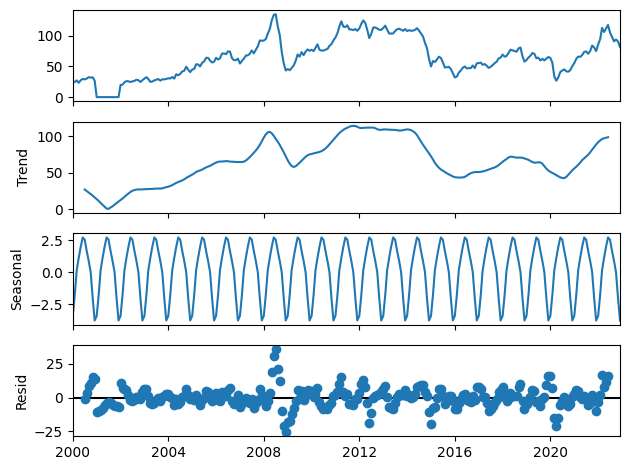

In [113]:
#Decompose the time series data
df_filled = df.fillna(0)  # Replace missing values with 0
df_filled = df_filled + 0.01  # Add a small constant value to avoid zero and negative values
decomposition = seasonal_decompose(df_filled, model='additive', period=12) 
# why do you use multiplicative model?
# Multiplicative model is used when the seasonal variation is increasing or decreasing over time.
# Additive model is used when the seasonal variation is constant over time.
#how do you know that the seasonal variation is increasing or decreasing over time?

fig = decomposition.plot()
plt.show()

In [114]:
# # DECOMPOSE THE TIME SERIES

# # Add a small constant value to the time series to avoid zero and negative values
# df['Price'] = df['Price'] + 0.01
# result = seasonal_decompose(df['Price'], model='multiplicative', period=12)

# # Plot the decomposed time series with plotly
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df['Date'], y=result.trend, mode='lines', name='Trend'))
# fig.add_trace(go.Scatter(x=df['Date'], y=result.seasonal, mode='lines', name='Seasonal'))
# fig.add_trace(go.Scatter(x=df['Date'], y=result.resid, mode='lines', name='Residual'))
# fig.update_layout(title='Decomposition of Brent Crude Oil Price', xaxis_title='Date', yaxis_title='Price')
# fig.show()

ValueError: This function does not handle missing values

In [118]:
df.fillna(0, inplace=True) # Replace missing values with 0

# use auto_arima to find the best parameters for the ARIMA model
model = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1872.197, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1792.882, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1838.183, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1757.954, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1787.810, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1759.801, Time=0.45 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1759.856, Time=0.34 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1763.160, Time=0.30 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1761.212, Time=0.60 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=1759.937, Time=0.73 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  276
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -874.977
Date:                            Fri, 08 Mar 2024   AIC                           1757.954
Time:                                    22:54:20   BIC                           1772.242
Sample:                                01-01-2000   HQIC                          1763.696
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3384      0.048      7.040      0.000       0.244       0.433
ar.S.L12      -0.6122      0.050    -12.139      0.000      -0.711      -0.513
ar.S.L24      -0.4017      0.061     -6.623      0.000      -0.521      -0.283
sigma2        44.2463      2.972     14.889      0.000      38.422      50.071
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               169.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.39
Prob(H) (two-sided):                  0.66   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'price' is the column of interest
data = df['Price']

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Create a dictionary to store the model results
aic_dict = {}

# Fit the ARIMA model for each pdq
for param in pdq:
    try:
        model = ARIMA(data, order=param)
        model_fit = model.fit()
        
        # Store the model results in the dictionary
        aic_dict[param] = model_fit.aic
    except:
        continue

# Convert the dictionary to a pandas DataFrame
aic_df = pd.DataFrame(list(aic_dict.items()), columns=['pdq', 'aic'])

# Convert 'pdq' values to strings
aic_df['pdq'] = aic_df['pdq'].astype(str)

aic_df

,pdq,aic
0,"(0, 0, 0)",2686.927485
1,"(0, 0, 1)",2350.171020
2,"(0, 0, 2)",2147.689064
3,"(0, 1, 0)",1774.128204
4,"(0, 1, 1)",1744.648168
5,"(0, 1, 2)",1741.097398
6,"(0, 2, 0)",1839.425150
7,"(0, 2, 1)",1775.992020
8,"(0, 2, 2)",1746.213352
9,"(1, 0, 0)",1785.146210


In [77]:
aic_df

,pdq,aic
0,"(0, 0, 0)",2524.799166
1,"(0, 0, 1)",2450.786922
2,"(0, 0, 2)",2448.567907
3,"(0, 0, 3)",2447.576813
4,"(0, 1, 0)",2506.874886
...,...,...
59,"(3, 2, 3)",2444.001012
60,"(3, 3, 0)",2713.201966
61,"(3, 3, 1)",2570.071710
62,"(3, 3, 2)",2555.660184


In [121]:
aic_df
# export to csv
# aic_df.to_csv('aic_df.csv')
min_aic = aic_df['aic'].idxmin()


In [122]:
min_aic

12

In [81]:
# Perform Dickey-Fuller test
dftest = adfuller(df['Price'].dropna(), autolag='AIC') # Run the test

# Create a Series with the Dickey-Fuller test results
# dftest[0:4] selects the first four elements of the tuple returned by adfuller:
# the test statistic, the p-value, the number of lags used, and the number of observations used
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']) 

# dftest[4].items() is a dictionary of the critical values for the test statistic at the 1 %, 5 %, and 10 % levels
for key,value in dftest[4].items(): # Loop through the dictionary
    dfoutput['Critical Value (%s)'%key] = value # Add the critical values to the Series

print(dfoutput) # Print the Series

Test Statistic                -9.827787e+00
p-value                        5.132453e-17
#Lags Used                     1.600000e+01
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


The p-value(=0.168104) is greater than 0.05, so we fail to reject the null hypothesis that the time series is non-stationary.


In [82]:
# Differencing the series
df['Price_diff'] = df['Price'] - df['Price'].shift(1)

# Dropping missing values
df.dropna(inplace=True)

# Perform Dickey-Fuller on differenced series
print('Results of Dickey Fuller Test on Differenced Series:')
dftest = adfuller(df['Price_diff'].dropna(), autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test on Differenced Series:
Test Statistic                -7.559362e+00
p-value                        3.038922e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


C:\Users\jnopa\AppData\Local\Temp\ipykernel_1132\2593097631.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jnopa\AppData\Local\Temp\ipykernel_1132\2593097631.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The p-value in your output is 2.667700e-25 (a very small number close to 0), which is less than the common significance level 0.05. This means we reject the null hypothesis of the Augmented Dickey-Fuller test, which states that the time series has a unit root and is non-stationary.

In simpler terms, your differenced time series is likely stationary. This means you've successfully transformed your time series and can proceed with the next steps of your analysis.

In [83]:
# plot the differenced series
fig = px.line(df, x=df.index, y='Price_diff', title='Differenced Brent Crude Oil Price Over Time') # Create a line plot using plotly express
fig.show() # Display the plot


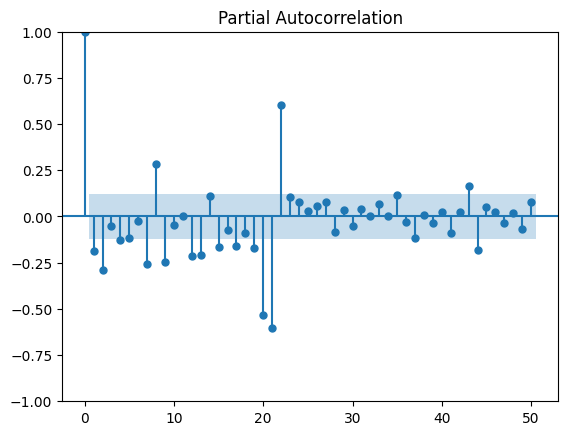

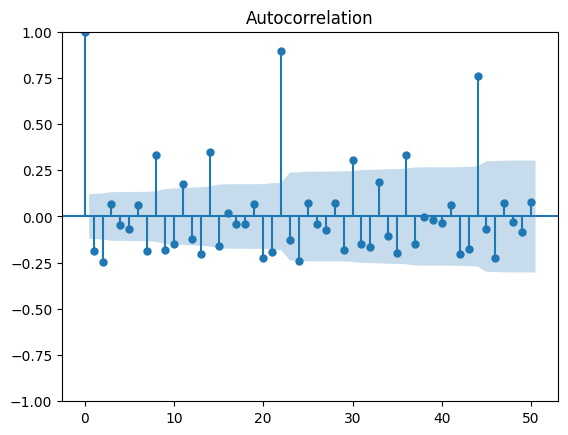

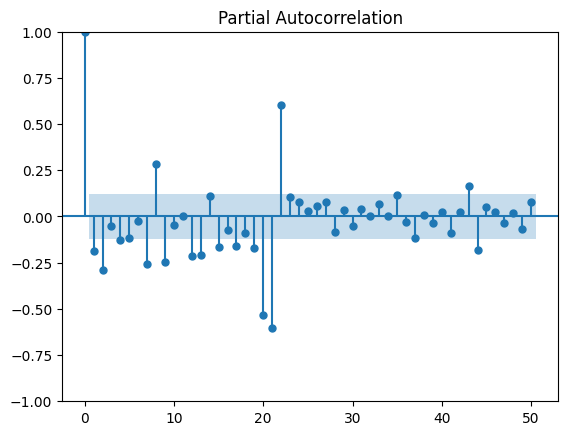

In [84]:

# Plot the ACF
plot_acf(df['Price_diff'], lags=50)

# Plot the PACF
plot_pacf(df['Price_diff'], lags=50)

In [25]:
# Fit an ARIMA model
model = ARIMA(df['Price'], order=(3, 2, 3))
model_fit = model.fit()


d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [26]:

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  263
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -809.857
Date:                Thu, 07 Mar 2024   AIC                           1633.714
Time:                        23:04:13   BIC                           1658.666
Sample:                             0   HQIC                          1643.744
                                - 263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8054      0.053    -15.144      0.000      -0.910      -0.701
ar.L2         -0.4619      0.062     -7.507      0.000      -0.582      -0.341
ar.L3          0.3400      0.053      6.459      0.0

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX(1, 1, 1)x(1, 1, 1, 12) model
model = SARIMAX(df['Price'], order=(3, 2, 3), seasonal_order=(3, 2, 3,12))
model_fit = model.fit()

# Print out the statistics
print(model_fit.summary())

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

d:\DEV WORK\Data Science Library\ML-For-Beginners\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  263
Model:             SARIMAX(3, 2, 3)x(3, 2, 3, 12)   Log Likelihood                -798.174
Date:                            Thu, 07 Mar 2024   AIC                           1622.347
Time:                                    23:04:32   BIC                           1667.432
Sample:                                         0   HQIC                          1640.519
                                            - 263                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8164      0.070    -11.739      0.000      -0.953      -0.680
ar.L2         -0.4521      0.081   

In [28]:
# Define the preprocess_for_lstm function
def preprocess_for_lstm(data):
    # Implement your data preprocessing logic here
    pass

# Assuming df is your DataFrame and 'price' is the column of interest
# Preprocess your data to fit into LSTM model
X_train, y_train, X_test, y_test = preprocess_for_lstm(df['Price'])

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit the model
model.fit(X_train, y_train, epochs=200, verbose=0)

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
df

,Price,Price_diff
Date,,
2000-03-01,27.26,2.68
2000-04-01,23.29,-3.97
2000-05-01,27.40,4.11
2000-06-01,29.63,2.23
2000-07-01,28.77,-0.86
...,...,...
2022-08-01,97.75,-7.40
2022-09-01,90.58,-7.17
2022-10-01,93.61,3.03


In [ ]:
df.head()

,Price,Price_diff
Date,,
2000-03-01,27.26,2.68
2000-04-01,23.29,-3.97
2000-05-01,27.40,4.11
2000-06-01,29.63,2.23
2000-07-01,28.77,-0.86


In [ ]:
# df = df.drop(['Year','Variables', 'Month'], axis=1) 
# Drop the 'Year' and 'Month' columns


prophet_df = df.drop(['Price_diff'], axis=1)
prophet_df

,Price
Date,
2000-03-01,27.26
2000-04-01,23.29
2000-05-01,27.40
2000-06-01,29.63
2000-07-01,28.77
...,...
2022-08-01,97.75
2022-09-01,90.58
2022-10-01,93.61


In [ ]:
# Set 'Date' as index
prophet_df.set_index('Date', inplace=True) 
prophet_df


KeyError: "None of ['Date'] are in the columns"

In [ ]:
# Prophet requires the variable names in the time series to be
# y for the response, and ds for the date
prophet_df.columns(['ds', 'y'])
prophet_df.head()

TypeError: 'Index' object is not callable

In [ ]:


model = Prophet(interval_width=0.95, yearly_seasonality=True, monthly_seasonality=True, seasonality_mode='additive')
model.fit(df)

# Make future predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '%pip'


NameError: name 'fbprophet' is not defined